In [1]:
from PIL import Image
import os
import random
import math
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage  

In [2]:
random.seed(0)
ia.seed(0)

In [3]:
base_path = "./datasets/bb-14/train"
destination = "./datasets/bb-14-aug"
crop_size = 224

In [4]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([
        iaa.ContrastNormalization((0.66, 1.5)),
        iaa.Multiply((0.7, 1.3)),
        iaa.Grayscale(alpha=(0.0, 0.15))
    ]),
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 1)),
        iaa.AverageBlur(k=(2, 3)),
        iaa.MedianBlur(k=(3)),
        iaa.BilateralBlur(d=(3, 5), sigma_color=(10, 50), sigma_space=(10, 50)),
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.01 * 255)),
        iaa.ElasticTransformation(alpha=2, sigma=1)
    ])
])

rotate = iaa.Affine(rotate=(-90, 90))

/home/p.kuznetsov/runaway/venv/lib/python3.9/site-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [5]:
def get_bb_from_line(line, image_height, image_width):
    data = line.strip().replace("\n", " ").split()
    
    center_x = float(data[1]) * image_width
    center_y = float(data[2]) * image_height
    
    bb_width = float(data[3]) * image_width
    bb_height = float(data[4]) * image_height

    x1 = center_x - bb_width / 2
    y1 = center_y - bb_height / 2
    x2 = center_x + bb_width / 2
    y2 = center_y + bb_height / 2

    return BoundingBox(x1, y1, x2, y2)

    
def augment_image_and_boxes(image, lines, sequence):
    image_np = np.array(image, dtype=np.uint8)
    
    boxes = []
    for line in lines:
        boxes.append(get_bb_from_line(line, image.height, image.width))

    boundingBoxesOnImage = BoundingBoxesOnImage(boxes, shape=image_np.shape)
    
    image_aug_np, bboxes_augmentated = sequence(image=image_np, bounding_boxes=boundingBoxesOnImage)
    
    image_aug_pil = Image.fromarray(image_aug_np)
    
    return image_aug_pil, bboxes_augmentated

In [6]:
mask_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".txt"):
            mask_paths.append(os.path.join(root, file))

In [7]:
image_and_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            #mask_path = os.path.join(base_path, image_path.split("/")[2], "labels", os.path.basename(image_path).replace(".jpg", ".txt"))
            mask_path = os.path.join(base_path, "labels", os.path.basename(image_path).replace(".jpg", ".txt"))
            try:
                with open(mask_path, "r") as mask_file:
                    lines = mask_file.readlines()
                    empty = len(lines) == 0
                    image_and_paths.append((image, lines, file, empty))
            except FileNotFoundError:
                print(f"File not found: {mask_path}")
                lines = []
                empty = True
                image_and_paths.append((image, lines, file, empty))

In [8]:
count_dict = {}

for image_and_path in image_and_paths:
    _, _, s, _ = image_and_path
    number = s.split('_')[0]
    try:
        number = int(number)
    except:
        print(number)
        if -1 in count_dict:
            count_dict[-1] += 1
        else:
            count_dict[-1] = 1
        continue

    if number in count_dict:
        count_dict[number] += 1
    else:
        count_dict[number] = 1

sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

# total = 0
# for number, count in sorted_counts:
#     print(f"Number {number}: {count} instance(s)")

2021-09-01
2021-11-19
2019-09-01
2022-02-07
2019-12-29
2021-10-10
2021-12-29
2019-10-10
2022-09-01
2021-03-19


In [9]:
test_numbers = []
total = 0
for number, count in sorted_counts:
    if (count > 1 and count < 6) and number not in test_numbers:
        test_numbers.append(number)
        total += count
print(f"Total: {total}")

Total: 163


In [10]:
test_image_and_paths = []
for image_and_path in image_and_paths:
    image, lines, file, empty = image_and_path
    try:
        number = int(file.split('_')[0])
    except:
        number = -1
    if number in test_numbers:
        test_image_and_paths.append(image_and_path)

In [11]:
from copy import deepcopy

val_image_and_paths = deepcopy(test_image_and_paths)

In [12]:
train_image_and_paths = []
for image_and_path in image_and_paths:
    image, lines, file, empty = image_and_path
    try:
        number = int(file.split('_')[0])
    except:
        number = -1
    if number not in test_numbers:
        train_image_and_paths.append(image_and_path)

In [13]:
train_rotated = []
for crop in train_image_and_paths:
    for _ in range(4):
        image, lines, _, _ = crop
        image, bboxes = augment_image_and_boxes(image, lines, rotate)
        train_rotated.append((image, bboxes))

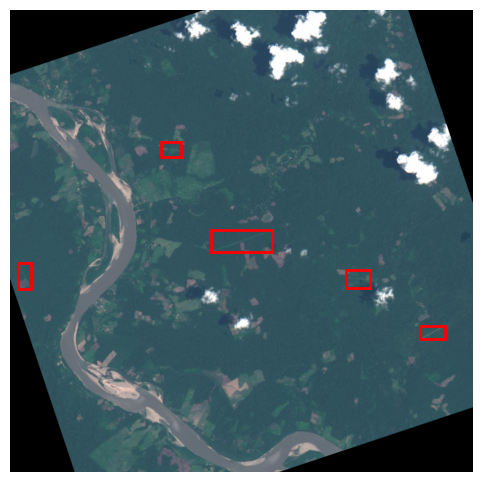

In [14]:
import matplotlib.pyplot as plt

image = train_rotated[0][0]
bboxes = train_rotated[0][1]
# Convert PIL Image to NumPy array
img_array = np.array(image)

# Create a Matplotlib figure and axis
plt.figure(figsize=(8, 6))
plt.imshow(img_array)
plt.axis('off')  # Hide axis

# Loop over all bounding boxes
for bbox in bboxes.bounding_boxes:
    # Extract the top-left corner of the bounding box
    x1, y1 = bbox.x1, bbox.y1
    # Calculate the width and height of the bounding box
    width = bbox.x2 - bbox.x1
    height = bbox.y2 - bbox.y1
    # Create a Rectangle patch
    rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    plt.gca().add_patch(rect)

# Show the image
plt.show()

In [15]:
train_rotated = [train_rotated[0]]

In [17]:
def crop(image, bboxes):
    while True:
        width, height = image.size
        empty = False
        if bbox is None:
            empty = True
            x_min_valid = 0
            x_max_valid = width - crop_size
            y_min_valid = 0
            y_max_valid = height - crop_size
        else:
            relative_x = [bbox.x1, bbox.x2]

            relative_y = [bbox.y1, bbox.y2]
            
            x_min = min(relative_x)
            x_max = max(relative_x)
            y_min = min(relative_y)
            y_max = max(relative_y)

            x_min_valid = max(0, x_max - crop_size)
            x_max_valid = min(width - crop_size, x_min)
            y_min_valid = max(0, y_max - crop_size)
            y_max_valid = min(height - crop_size, y_min)

            if x_min_valid >= x_max_valid or y_min_valid >= y_max_valid or x_max_valid - x_min_valid < 0.5 or y_max_valid - y_min_valid < 0.5:
                print("Invalid crop for image " + image_path)
                return None

        crop_x = random.randint(math.ceil(x_min_valid), math.floor(x_max_valid))
        crop_y = random.randint(math.ceil(y_min_valid), math.floor(y_max_valid))

        crop = image.crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size))

        pixels = crop.load()

        black = 0
        for x in range(crop_size):
            for y in range(crop_size):
                if pixels[x, y] == (0, 0, 0):
                    black += 1
        if black < 0.3 * crop_size * crop_size:
            break
    
    if not empty:
        string = "0 "
        center_x = (bbox.x1 + bbox.x2) / 2 - crop_x
        center_y = (bbox.y1 + bbox.y2) / 2 - crop_y
        bb_width = bbox.x2 - bbox.x1
        bb_height = bbox.y2 - bbox.y1
        string += f"{center_x / crop_size} {center_y / crop_size} {bb_width / crop_size} {bb_height / crop_size}"
    else:
        string = ''
    return (crop, string)

In [ ]:
train_cropped = []
for i, rotated in enumerate(train_rotated):
    image, bboxes = rotated
    train_cropped.extend(crop(image, bboxes))

In [ ]:
import matplotlib.pyplot as plt

k=30
image = multiple[k][0]
line = multiple[k][1]

points = line.replace("\n", " ").split()[1:]
x, y, w, h = [float(point) * crop_size for point in points]

# Convert PIL Image to NumPy array
img_array = np.array(image)

# Create a Matplotlib figure and axis
plt.figure(figsize=(8, 6))
plt.imshow(img_array)
plt.axis('off')  # Hide axis

plt.gca().add_patch(plt.Rectangle((x - w/2, y - h/2), w/2, h, linewidth=2, edgecolor='r', facecolor='none'))

# Show the image
plt.show()

In [ ]:
test_cropped = []
for i, rotated in enumerate(test_image_and_paths):
    image, lines, _, _ = rotated
    image, bboxes = augment_image_and_boxes(image, lines, seq)
    if len(bboxes.bounding_boxes) == 0:
        cropped = crop(image, None)
        if cropped is not None:
            test_cropped.append(cropped)
    else:
        for bbox in bboxes.bounding_boxes:
            cropped = crop(image, bbox)
            if cropped is not None:
                test_cropped.append(cropped)

In [20]:
val_cropped = []
for i, rotated in enumerate(val_image_and_paths):
    image, lines, _, _ = rotated
    image, bboxes = augment_image_and_boxes(image, lines, seq)
    if len(bboxes.bounding_boxes) == 0:
        cropped = crop(image, None)
        if cropped is not None:
            val_cropped.append(cropped)
    else:
        for bbox in bboxes.bounding_boxes:
            cropped = crop(image, bbox)
            if cropped is not None:
                val_cropped.append(cropped)

In [20]:
for i in range(len(train_cropped)):
    image, line = train_cropped[i]
    try:
        image, bboxes = augment_image_and_boxes(image, line, seq)
    except:
        continue
    line = ''
    if len(bboxes.bounding_boxes) > 0: 
        for bbox in bboxes.bounding_boxes:
            line += "0 "
            center_x = (bbox.x1 + bbox.x2) / 2
            center_y = (bbox.y1 + bbox.y2) / 2
            bb_width = bbox.x2 - bbox.x1
            bb_height = bbox.y2 - bbox.y1
            line += f"{center_x / crop_size} {center_y / crop_size} {bb_width / crop_size} {bb_height / crop_size}\n"

    train_cropped[i] = (image, line)

In [24]:
# import re
# for i in range(len(train_cropped)):
#     matches = re.findall(r'0\.\d+0\.\d+', train_cropped[i][1])
#     if len(matches) > 1:
#         print(matches)
#         break

In [ ]:
print("Train size: " + str(len(train_cropped)))
# print("Val size: " + str(len(val_cropped)))
print("Test size: " + str(len(test_cropped)))

In [ ]:
from matplotlib import pyplot as plt
for i in range(0, len(train_cropped), 250):
    image, data = train_cropped[i]
    # Convert PIL Image to NumPy array
    img_array = np.array(image)
    
    # Create a Matplotlib figure and axis
    plt.figure(figsize=(8, 6))
    plt.imshow(img_array)
    plt.axis('off')  # Hide axis
    
    # Parse the data string to extract coordinates
    points = data.strip().split()

    if len(points) == 0:
        continue
    
    x, y, w, h = [float(p) * crop_size for p in points[1:]]
    plt.gca().add_patch(plt.Rectangle((x - w/2, y - h/2), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    
    plt.show()

In [22]:
folder = "train"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in train_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [23]:
folder = "test"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in test_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [24]:
folder = "valid"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
# for image, data in val_cropped:
for image, data in test_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)